# setup

In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import sys

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib notebook
# %matplotlib qt

from __future__ import print_function

drive_path = '/data/dynamic-brain-workshop/visual_behavior'
manifest_file = 'visual_behavior_data_manifest.csv'
manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

In [2]:
experiment_id = 670396087
experiment_container_id = manifest[manifest.experiment_id==experiment_id].experiment_container_id.values[0]

dataset= VisualBehaviorOphysDataset(experiment_id, cache_dir=drive_path)
dataset.metadata

,ophys_experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,experiment_date,specimen_id,ophys_frame_rate,stimulus_frame_rate
670396087,670396087,None,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355471,2018-03-06,644831080,31.0,60.0


# trial stimulus parameters

In [3]:
from util.trial_analysis import get_trial_len
trial_len = get_trial_len(dataset)

In [4]:
# import analysis object
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [5]:
# get image names
stim_table = dataset.get_stimulus_table()
im_name = stim_table['image_name'].unique()
num_im = len(im_name)

# get timestamps
stim_ts = dataset.get_timestamps_stimulus()
ophys_ts = dataset.get_timestamps_ophys()

In [6]:
# dff traces
_, dff = dataset.get_dff_traces()
num_cell = dff.shape[0]

In [36]:
# select long trials
repeat_start = 1 # start from which repeat in the trial (start with 1)
len_cutoff = 10 # length of trials

# stimlus duration in frames
stim_duration_frame = int(np.ceil(analysis.stimulus_duration*analysis.ophys_frame_rate))

# get response matrix for each flash in each trial
# repeat_resp = np.zeros([num_cell, num_im, len_cutoff, stim_duration_frame*2]) # full response matrix before averaging
avg_resp = np.zeros([num_cell, num_im, len_cutoff]) # num_neuron by num_im by len_cutoff

for im in range(num_im): # loop over image templates

    for trial_block_id in np.where(trial_len['image']==im_name[im])[0]: # loop over trials for the image template

        if trial_len['trial_length'][trial_block_id] < len_cutoff + repeat_start: # skip short trials
            continue
        
        for repeat_ind, j in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial
            flash_start = stim_table['start_time'][j]
            #flash_end = stim_table['end_time'][j]
            #ophys_frames = np.where((ophys_ts >= flash_start) & (ophys_ts <= flash_end))[0]
            baseline_frames = ophys_frames - len(ophys_frames)
            stim_start = np.argmax(ophys_ts >= flash_start)
            stim_frames = np.arange(stim_start, stim_start+stim_duration_frame)
            baseline_frames = np.arange(stim_start-stim_duration_frame, stim_start)

            for neuron in range(num_cell):
#                 repeat_resp[neuron, im, repeat_ind, :] = dff[neuron, np.concatenate((baseline_frames, stim_frames))]
                avg_resp[neuron, im, repeat_ind] = dff[neuron, ophys_frames].mean() - dff[neuron, baseline_frames].mean()

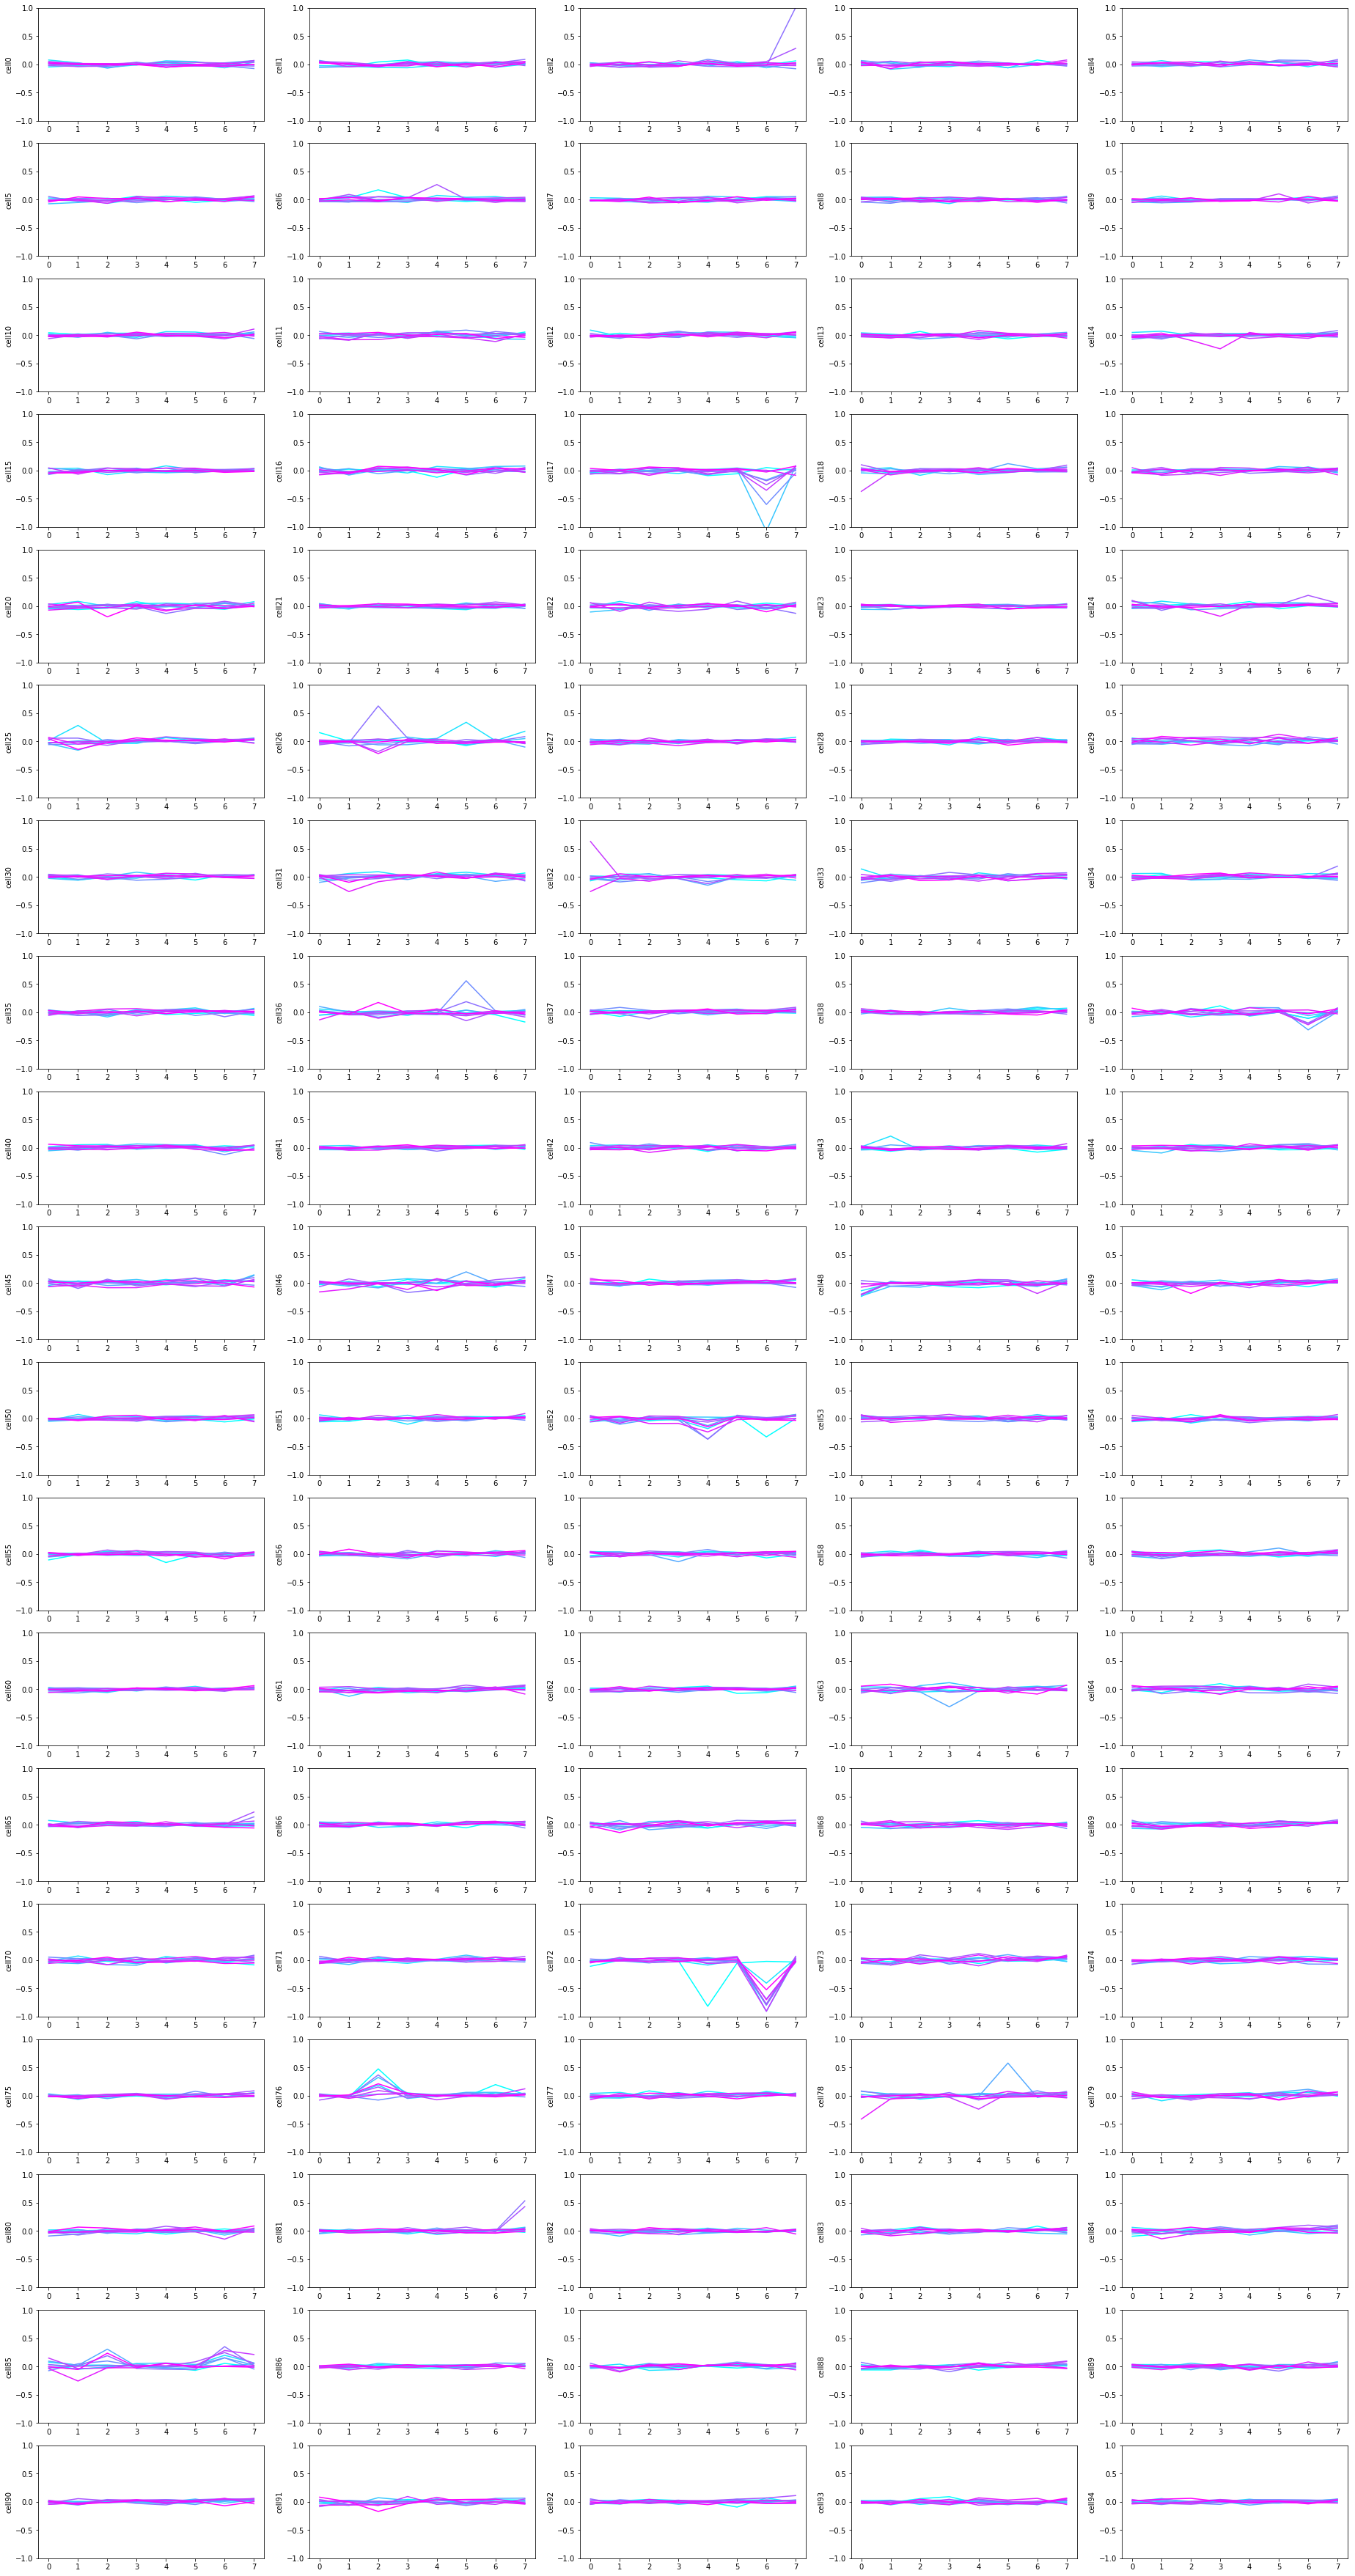

In [8]:
# set plot color
color_idx = np.linspace(0, 1, len_cutoff)

# loop over cells
num_cell_per_row = 5
num_row = int(np.ceil(num_cell/num_cell_per_row))

# create plot
fig, axes = plt.subplots(num_row, num_cell_per_row)
fig.set_size_inches(32, 64)

for row in range(num_row):
    
    cell_start = row*num_cell_per_row
    cell_end = np.max([row*num_cell_per_row+1, num_cell])
    for cell, ax in zip(np.arange(cell_start, cell_end), axes[row,:]): # loop over cells
        
        for i, c in zip(range(len_cutoff),color_idx): # loop over repeats
            ax.plot(avg_resp[cell,:,i], color=plt.cm.cool(c))
            ax.set_ylabel('cell' + str(cell))
#             ax.set_ylim([-1, 1])
#             ax.legend(range(len_cutoff), loc='upper right')
#         ax.title('cell ' + str(cell_start) + ' to ' + str(cell_end))

plt.show()

In [50]:
trial_rsp_mat.shape

(31, 10, 16)

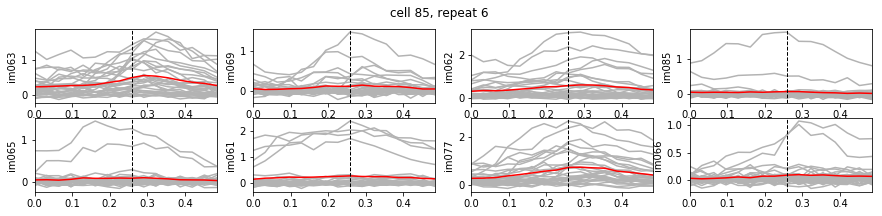

In [59]:
cell = 85 # cell index, start from 0
repeat = 6 # which repeat to plot, start from 0

fig, axes = plt.subplots(2, 4, figsize=[15,3])

# timestamps for repeats
repeat_ts = np.arange(0, stim_duration_frame*2) / analysis.ophys_frame_rate

# plot repeat responses for each image template
for im, ax in zip(im_name, axes.reshape(-1)):
    
    im_trials = np.where((trial_len['image']==im) & (trial_len['trial_length']>=len_cutoff))[0]
    trial_rsp_mat = np.zeros([len(im_trials), len_cutoff, int(stim_duration_frame)*2])
    
    for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

        for j, repeat_ind in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial
            
            # define frames for current trial block, current repeat
            flash_start = stim_table['start_time'][repeat_ind]
            baseline_frames = ophys_frames - len(ophys_frames)
            stim_start = np.argmax(ophys_ts >= flash_start)
            frames = np.arange(stim_start-stim_duration_frame, stim_start+stim_duration_frame)
            
            # store result
            trial_rsp_mat[i, j, :] = dff[cell, frames]
            
    # plot individual repeats
    for i in range(len(im_trials)):
        ax.plot(repeat_ts[:stim_duration_frame*2], trial_rsp_mat[i, repeat, :], color=(0.7, 0.7, 0.7))
    
    # plot average response
    ax.plot(repeat_ts[:stim_duration_frame*2], trial_rsp_mat[:, repeat, :].mean(axis=0), color='r', linewidth=1.5)

    # plot stim time
    ax.axvline(x=repeat_ts[int(stim_duration_frame)], color='k', linewidth=1, linestyle='--')
    ax.set_xlim([repeat_ts[0], repeat_ts[-1]])
    ax.set_ylabel(im)
    
    # stimuli
#     im_trials = np.where(stim_table['image_name'].values==im_name[im])[0]
#     trial_rsp_mat = np.zeros([len(im_trials), int(stim_duration_frame)*2])

    #for ii, stim in stim_table.loc[im_trials].iterrows():
#     for ii in np.arange(len(im_trials)):
        
        # find frames of current repeat
#         start_frame = np.argmax((ophys_ts>=stim_table['start_time'].values[im_trials[ii]]))
#         frames = np.arange(start_frame-stim_duration_frame, start_frame+stim_duration_frame)

        # store result
#         trial_rsp_mat[ii,:] = dff[cell, frames]

        # plot repeat
#         ax.plot(repeat_ts[:stim_duration_frame*2], dff[cell, frames], color=(0.7, 0.7, 0.7))

#     # plot average response
#     ax.plot(repeat_ts[:stim_duration_frame*2], trial_rsp_mat.mean(axis=0), color='r', linewidth=1.5)

#     # plot stim time
#     ax.axvline(x=repeat_ts[int(stim_duration_frame)], color='k', linewidth=1, linestyle='--')
#     ax.set_xlim([repeat_ts[0], repeat_ts[-1]])
#     ax.set_ylabel(im_name[im])

plt.suptitle('cell ' + str(cell) + ', repeat ' + str(repeat))
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x = np.arange(1,9,1)
y = np.arange(0,10,1)
X, Y = np.meshgrid(x, y)

# num_images by num_repeats
zs = avg_resp[0,:,:]
Z = zs.reshape(X.shape)

ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)
ax.set_xlabel('Image ID')
ax.set_ylabel('$t_k$')
ax.set_zlabel('Response')

plt.show()